<a href="https://colab.research.google.com/github/iNata23i/Supply-chain-forecast/blob/main/Supply_chain_forecasts_for_a_manufacturing_beverage_company.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Explore the data to understand how order quantities vary by warehouse over time


In [4]:
from google.colab import files

uploaded = files.upload()

Saving US_Regional_Sales_Data.xlsx - Sales Orders Sheet.csv to US_Regional_Sales_Data.xlsx - Sales Orders Sheet.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import itertools
import warnings
warnings.filterwarnings("ignore")


In [6]:
# Load and inspect the data
data = pd.read_csv('US_Regional_Sales_Data.xlsx - Sales Orders Sheet.csv')

# Check the first few rows
print(data.head())

# Check data types and missing values
print(data.info())

   OrderNumber Sales Channel WarehouseCode ProcuredDate  OrderDate   ShipDate  \
0  SO - 000101      In-Store  WARE-UHY1004   31/12/2017  31/5/2018  14/6/2018   
1  SO - 000102        Online  WARE-NMK1003   31/12/2017  31/5/2018  22/6/2018   
2  SO - 000103   Distributor  WARE-UHY1004   31/12/2017  31/5/2018  21/6/2018   
3  SO - 000104     Wholesale  WARE-NMK1003   31/12/2017  31/5/2018   2/6/2018   
4  SO - 000105   Distributor  WARE-NMK1003    10/4/2018  31/5/2018  16/6/2018   

  DeliveryDate CurrencyCode  _SalesTeamID  _CustomerID  _StoreID  _ProductID  \
0    19/6/2018          USD             6           15       259          12   
1     2/7/2018          USD            14           20       196          27   
2     1/7/2018          USD            21           16       213          16   
3     7/6/2018          USD            28           48       107          23   
4    26/6/2018          USD            22           49       111          26   

   Order Quantity  Discount Appl

In [7]:
unique_values = data['WarehouseCode'].unique()

print(unique_values)

['WARE-UHY1004' 'WARE-NMK1003' 'WARE-PUJ1005' 'WARE-XYS1001'
 'WARE-MKL1006' 'WARE-NBV1002']


##Aggregate order quantities by WarehouseCode and OrderDate

In [8]:
# Convert date columns to datetime format
data['OrderDate'] = pd.to_datetime(data['OrderDate'], format='%d/%m/%Y')

# Create a year-month column for aggregation
data['YearMonth'] = data['OrderDate'].dt.to_period('M')

# Aggregate order quantities by warehouse and month Группирует по складу и по месяцу
monthly_warehouse_demand = data.groupby(['WarehouseCode', 'YearMonth'])['Order Quantity'].sum().reset_index()

# Convert YearMonth to datetime for time series analysis
monthly_warehouse_demand['YearMonth'] = monthly_warehouse_demand['YearMonth'].dt.to_timestamp()

#print aggregated order quantities by warehouse and month
print(monthly_warehouse_demand)

    WarehouseCode  YearMonth  Order Quantity
0    WARE-MKL1006 2018-06-01              99
1    WARE-MKL1006 2018-07-01             142
2    WARE-MKL1006 2018-08-01              96
3    WARE-MKL1006 2018-09-01             143
4    WARE-MKL1006 2018-10-01             132
..            ...        ...             ...
185  WARE-XYS1001 2020-08-01             153
186  WARE-XYS1001 2020-09-01             206
187  WARE-XYS1001 2020-10-01             187
188  WARE-XYS1001 2020-11-01             163
189  WARE-XYS1001 2020-12-01             199

[190 rows x 3 columns]


In [9]:
total_by_warehouse = data.groupby('WarehouseCode')['Order Quantity'].sum().reset_index()
total_by_warehouse = total_by_warehouse.sort_values(by='Order Quantity', ascending=False)

print(total_by_warehouse)


  WarehouseCode  Order Quantity
2  WARE-NMK1003           11351
3  WARE-PUJ1005            6572
4  WARE-UHY1004            5765
5  WARE-XYS1001            5557
0  WARE-MKL1006            3816
1  WARE-NBV1002            3101


##Explore and Visualize Data

In [10]:
# Create a pivot table for easier visualization
pivot_data = monthly_warehouse_demand.pivot(index='YearMonth', columns='WarehouseCode', values='Order Quantity').fillna(0)

print(pivot_data)


WarehouseCode  WARE-MKL1006  WARE-NBV1002  WARE-NMK1003  WARE-PUJ1005  \
YearMonth                                                               
2018-05-01              0.0           0.0          19.0          10.0   
2018-06-01             99.0          66.0         443.0         159.0   
2018-07-01            142.0         105.0         448.0         190.0   
2018-08-01             96.0          81.0         454.0         245.0   
2018-09-01            143.0          78.0         409.0         211.0   
2018-10-01            132.0         107.0         304.0         205.0   
2018-11-01            160.0          97.0         369.0         194.0   
2018-12-01            159.0         150.0         465.0         191.0   
2019-01-01             87.0          57.0         408.0         308.0   
2019-02-01            105.0          68.0         286.0         207.0   
2019-03-01            123.0          43.0         338.0         173.0   
2019-04-01            147.0         135.0         3

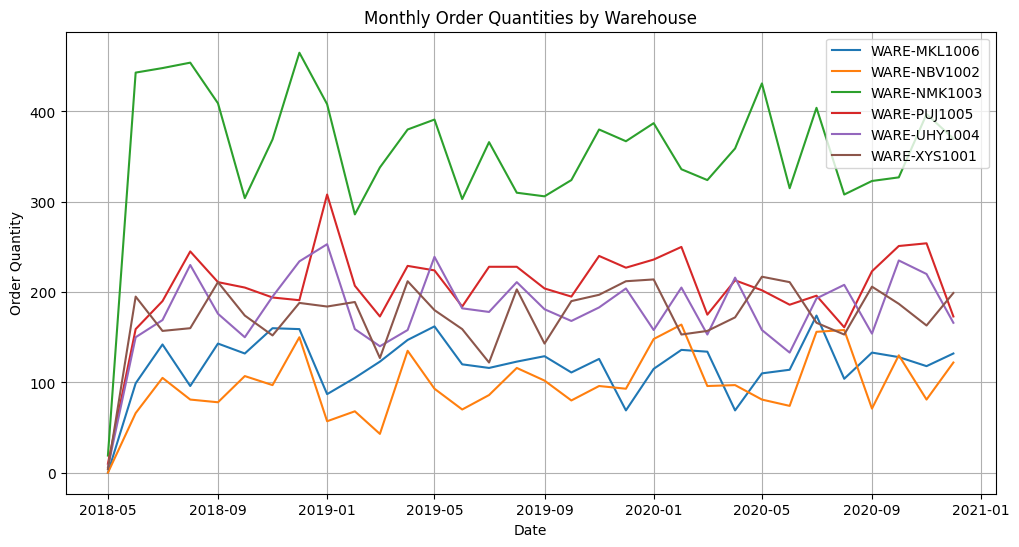

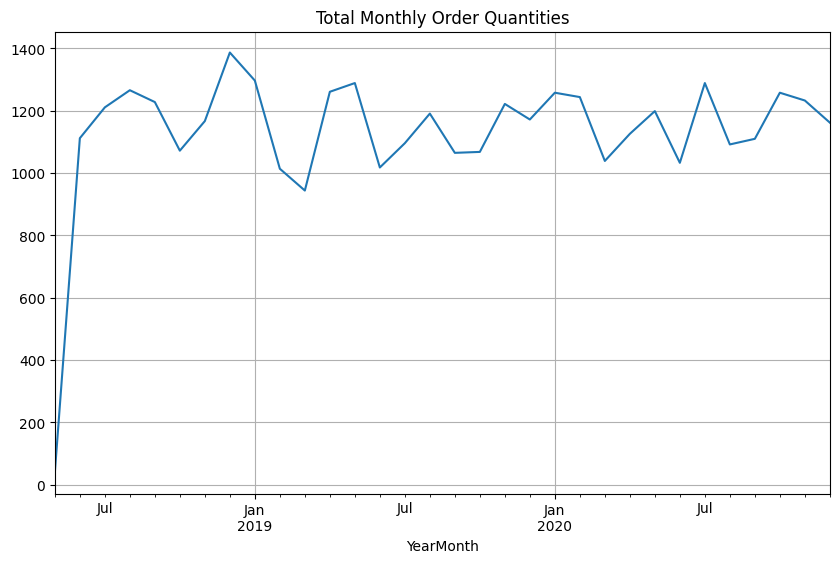

In [11]:
# Plot the monthly demand for each warehouse
plt.figure(figsize=(12, 6))
for warehouse in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[warehouse], label=warehouse)

plt.title('Monthly Order Quantities by Warehouse')
plt.xlabel('Date')
plt.ylabel('Order Quantity')
plt.legend()
plt.grid(True)
plt.show()

# Check for seasonality patterns
plt.figure(figsize=(10, 6))
monthly_totals = pivot_data.sum(axis=1)
monthly_totals.plot()
plt.title('Total Monthly Order Quantities')
plt.grid(True)
plt.show()

##Time Series Decomposition (разложение временного ряда)

In [ ]:
# Analyze one warehouse as an example
warehouse_code = pivot_data.columns[2]  # Choose the third warehouse
warehouse_data = pivot_data[warehouse_code]
print(warehouse_code)

WARE-NMK1003


#Build ARIMA AutoRegressive Integrated Moving Average
(Simple Forecasting Model):
#demand forecasting solution specifically focusing on order quantities by warehouse
(predicting future order quantities for each warehouse)




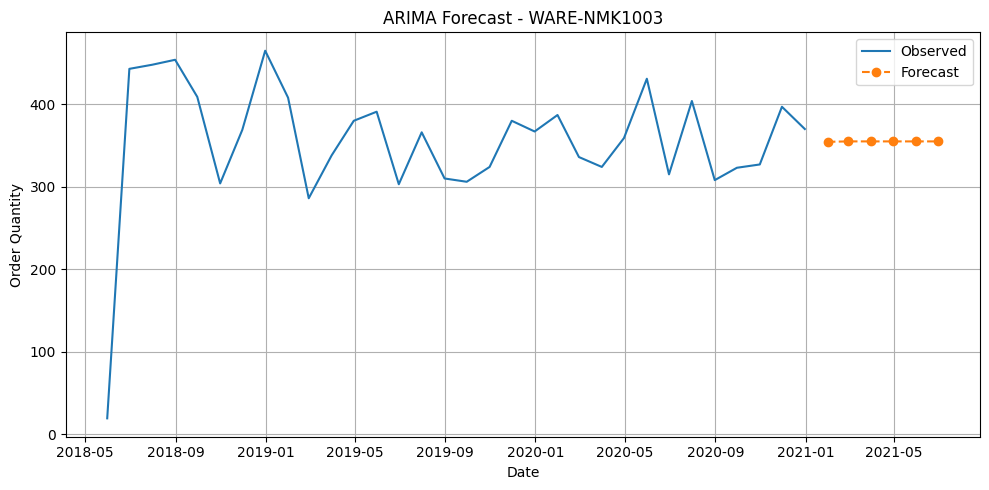

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

# STEP 1: Load the dataset
file_path = 'US_Regional_Sales_Data.xlsx - Sales Orders Sheet.csv'
df = pd.read_csv(file_path)

# STEP 2: Convert 'OrderDate' to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['OrderDate'])

# STEP 3: Aggregate order quantities by Warehouse and OrderDate
agg_df = df.groupby(['WarehouseCode', 'OrderDate'])['Order Quantity'].sum().reset_index()

# STEP 4: Select one warehouse for forecasting (e.g., 'WARE-NMK1003')
warehouse_code = 'WARE-NMK1003'
warehouse_df = agg_df[agg_df['WarehouseCode'] == warehouse_code]

# STEP 5: Resample by month -  мы изменяем временной масштаб с "по дням" на "по месяцам" ('M' = Month)
warehouse_ts = warehouse_df.set_index('OrderDate')['Order Quantity'].resample('M').sum()

# STEP 6: Fit ARIMA model (we'll use ARIMA(1,1,1) as a starting point)
model = ARIMA(warehouse_ts, order=(1, 1, 1))
model_fit = model.fit()

# STEP 7: Forecast next 6 months
forecast_steps = 6
forecast = model_fit.forecast(steps=forecast_steps)

# STEP 8: Plot original series and forecast
plt.figure(figsize=(10, 5))
plt.plot(warehouse_ts, label='Observed')
forecast_index = pd.date_range(start=warehouse_ts.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')
plt.plot(forecast_index, forecast, label='Forecast', linestyle='--', marker='o')
plt.title(f'ARIMA Forecast - {warehouse_code}')
plt.xlabel('Date')
plt.ylabel('Order Quantity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Building SARIMAX
#Make a revenue forecast by Sales Channel taking seasonality into account using



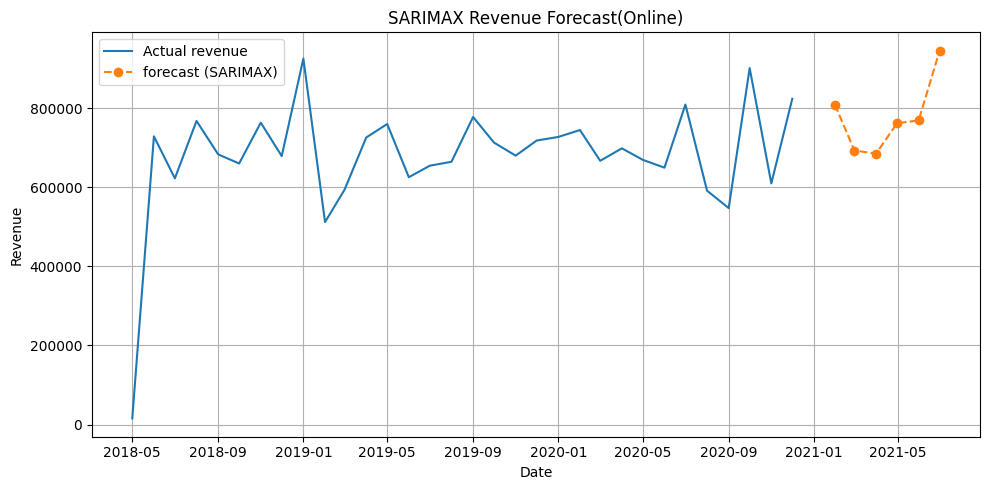

In [13]:
# import the necessary libraries
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 1. Convert dates
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['OrderDate'])

# 2. Calculate revenue
df['Unit Price'] = df['Unit Price'].astype(str).str.replace(',', '').astype(float)
df['Revenue'] = df['Unit Price'] * df['Order Quantity'] * (1 - df['Discount Applied'])

# 3. Select one sales channel, e.g., "Online"
channel_df = df[df['Sales Channel'] == 'Online']

# 4. Aggregate monthly revenue
channel_df['YearMonth'] = channel_df['OrderDate'].dt.to_period('M').dt.to_timestamp()
monthly_revenue = channel_df.groupby('YearMonth')['Revenue'].sum()

# 5. Train SARIMAX model
model = SARIMAX(monthly_revenue, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# 6. Forecast for the next 6 months
forecast = model_fit.forecast(steps=6)

# 7. Plot the forecast
forecast_index = pd.date_range(start=monthly_revenue.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='M')

plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue, label='Actual revenue')
plt.plot(forecast_index, forecast, label='forecast (SARIMAX)', linestyle='--', marker='o')
plt.title('SARIMAX Revenue Forecast(Online)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Sales Revenue Forecasting by Sales Channel with ARIMA


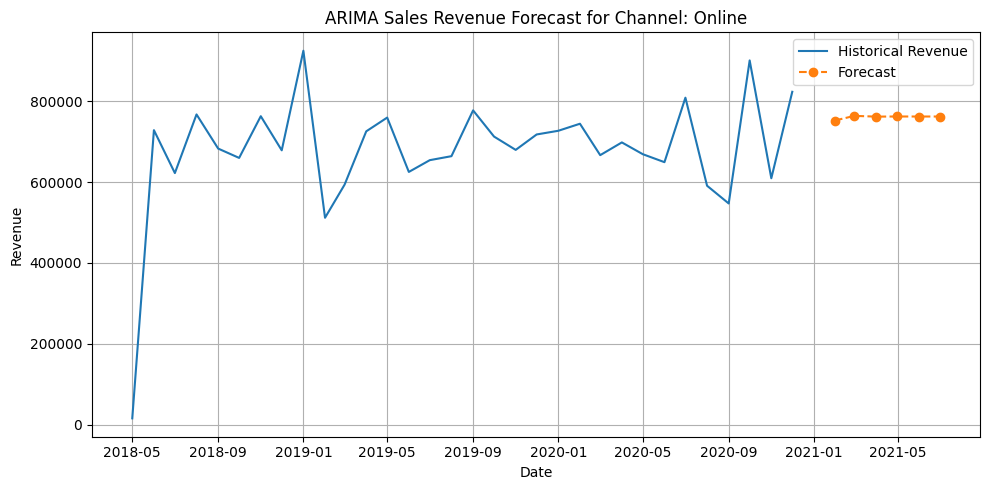

In [14]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Step 1: Ensure 'OrderDate' is in datetime format
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['OrderDate'])

# Step 2: Make sure 'Unit Price' is numeric (clean commas if needed)
df['Unit Price'] = df['Unit Price'].astype(str).str.replace(',', '').astype(float)

# Step 3: Calculate Revenue
df['Revenue'] = df['Unit Price'] * df['Order Quantity'] * (1 - df['Discount Applied'])

# Step 4: Create a "YearMonth" column for grouping
df['YearMonth'] = df['OrderDate'].dt.to_period('M').dt.to_timestamp()

# Step 5: Aggregate revenue by Sales Channel and Month
monthly_revenue = df.groupby(['Sales Channel', 'YearMonth'])['Revenue'].sum().reset_index()

# Step 6: Select a specific channel for forecasting (e.g., 'Online')
channel = 'Online'  # or try 'In-Store', 'Distributor', 'Wholesale'
channel_df = monthly_revenue[monthly_revenue['Sales Channel'] == channel]

# Step 7: Create a time series with date as index
channel_ts = channel_df.set_index('YearMonth')['Revenue']

# Step 8: Fit ARIMA model
model = ARIMA(channel_ts, order=(1, 1, 1))
model_fit = model.fit()

# Step 9: Forecast the next 6 months
forecast_steps = 6
forecast = model_fit.forecast(steps=forecast_steps)

# Step 10: Create future dates for the forecast
forecast_index = pd.date_range(start=channel_ts.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='M')

# Step 11: Plot historical data and forecast
plt.figure(figsize=(10, 5))
plt.plot(channel_ts, label='Historical Revenue')
plt.plot(forecast_index, forecast, label='Forecast', linestyle='--', marker='o')
plt.title(f'ARIMA Sales Revenue Forecast for Channel: {channel}')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
###repeat this code for other channels by changing:

channel = 'Online'
to 'In-Store', 'Distributor', or 'Wholesale'.

##Building individual time series forecasts for each sales channel using the ARIMA model, and visualizing the results.
I loop through each sales channel, build a separate ARIMA model, generate a 6-month forecast, and plot it.
(I skip channels with too little data, and handle any issues without crashing the script.)



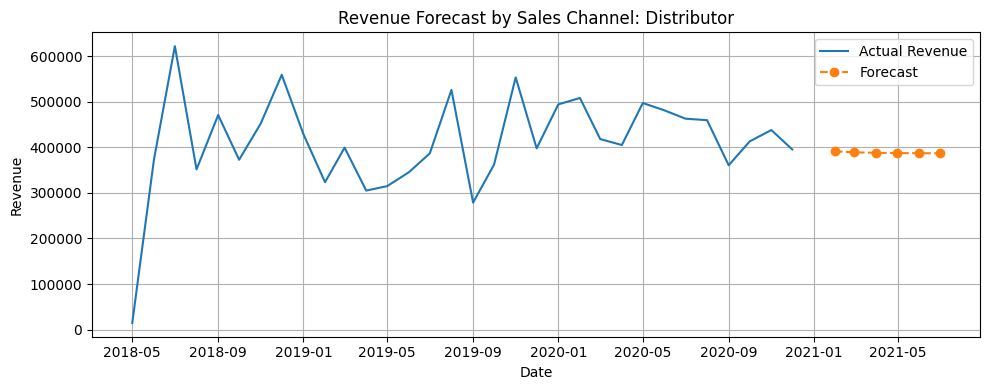

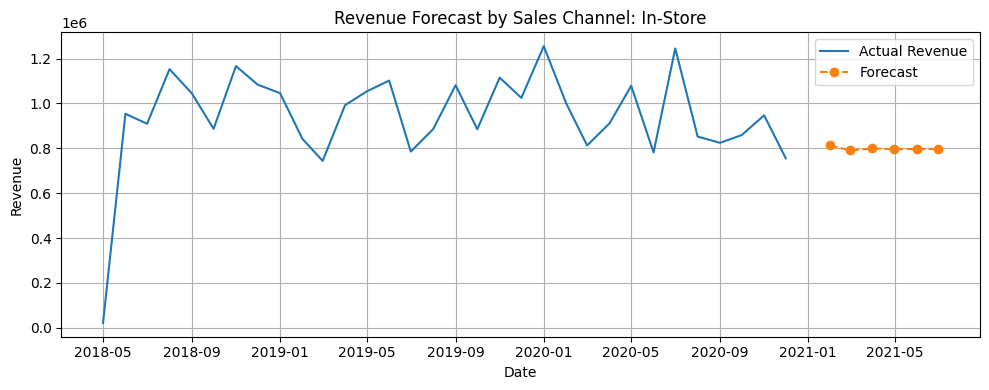

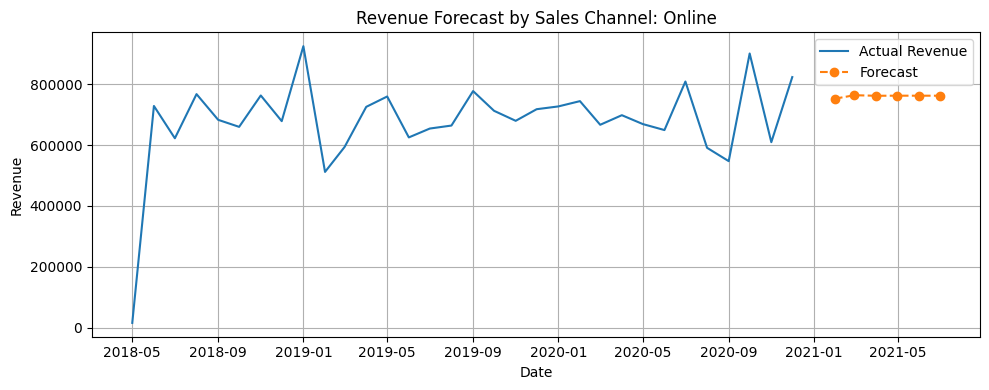

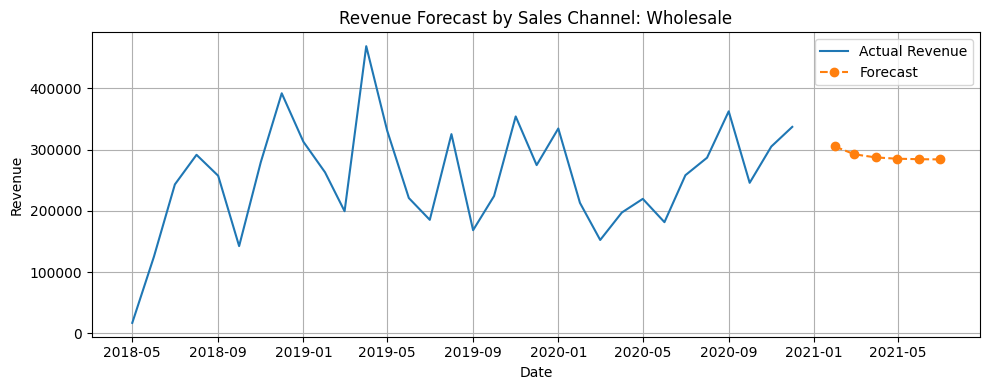

In [16]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# I have the dataframe `monthly_revenue`
sales_channels = monthly_revenue['Sales Channel'].unique()

for channel in sales_channels:
    # 1. Filter data for the current channel
    channel_df = monthly_revenue[monthly_revenue['Sales Channel'] == channel]
    channel_ts = channel_df.set_index('YearMonth')['Revenue']

    # Ensure the time series has sufficient data points (ARIMA models require longer series for stability)
    if len(channel_ts) < 10:
        print(f"⏭ Skipped channel {channel} — too few data points ({len(channel_ts)} points)")
        continue

    # 2. Build the ARIMA model
    try:
        model = ARIMA(channel_ts, order=(1, 1, 1))
        model_fit = model.fit()

        # 3. Forecast the next 6 months
        forecast = model_fit.forecast(steps=6)
        forecast_index = pd.date_range(start=channel_ts.index[-1] + pd.offsets.MonthBegin(1), periods=6, freq='M')

        # 4. Visualization
        plt.figure(figsize=(10, 4))
        plt.plot(channel_ts, label='Actual Revenue')
        plt.plot(forecast_index, forecast, label='Forecast', linestyle='--', marker='o')
        plt.title(f'Revenue Forecast by Sales Channel: {channel}')
        plt.xlabel('Date')
        plt.ylabel('Revenue')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Error for channel {channel}: {e}")


#Order Lead Time Forecasting
Objective: To predict the delivery lead time based on the difference between OrderDate and DeliveryDate

In [17]:
#Calculate LeadTime in days:
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True, errors='coerce')
df['DeliveryDate'] = pd.to_datetime(df['DeliveryDate'], dayfirst=True, errors='coerce')
df['LeadTime'] = (df['DeliveryDate'] - df['OrderDate']).dt.days


In [18]:
# Remove rows with invalid values:
df = df.dropna(subset=['LeadTime'])  # in case any date is missing
df = df[df['LeadTime'] >= 0]         # exclude negative lead times


In [ ]:
# Select features for the model:
# WarehouseCode (categorical)
# Order Quantity (numeric)
# _ProductID (categorical)
# (optional) Month, DayOfWeek — for capturing seasonality


In [19]:
# Prepare data for ML:
# Convert categorical variables to numeric using one-hot encoding:
from sklearn.preprocessing import OneHotEncoder

features = df[['WarehouseCode', 'Order Quantity', '_ProductID']]
features_encoded = pd.get_dummies(features, columns=['WarehouseCode', '_ProductID'])
target = df['LeadTime']


In [21]:
#Train the regression model:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f} days")


Mean Absolute Error (MAE): 7.26 days


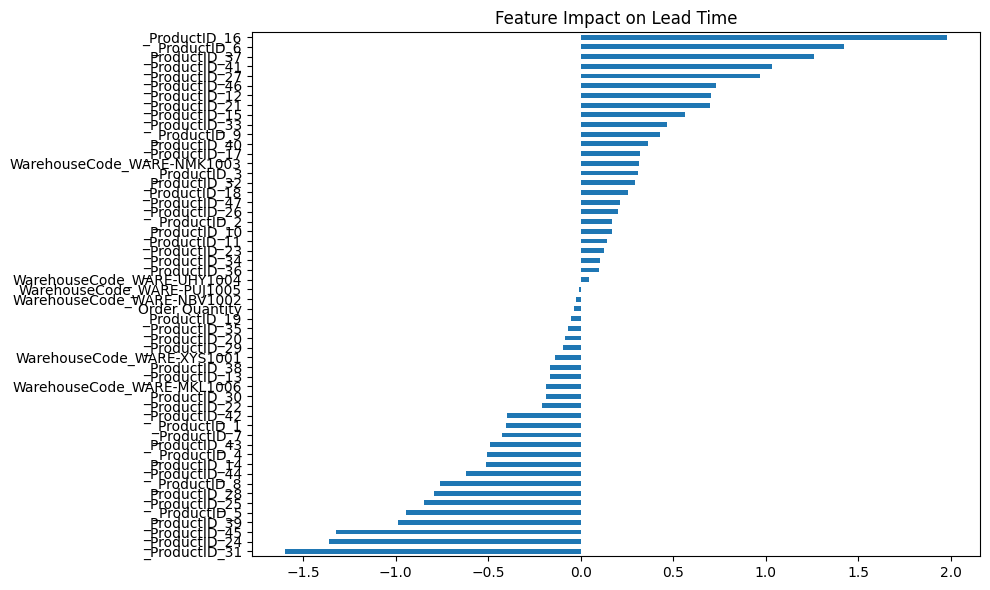

In [22]:
# Visualize feature importance:
import matplotlib.pyplot as plt

coeffs = pd.Series(model.coef_, index=X_train.columns).sort_values()
coeffs.plot(kind='barh', figsize=(10, 6), title='Feature Impact on Lead Time')
plt.tight_layout()
plt.show()


##Customer and Sales Team Performance Forecasting
(The goal: Predict future revenue by customer and by sales team)

Why this matters:

🧠 Helps identify which customers generate the most revenue

🔥 Evaluates the effectiveness of the Sales Team — who’s closing the best deals

📊 Supports better planning, bonuses, and retention strategies




Calculates LeadTime = DeliveryDate - OrderDate

Converts categorical variables into numerical format using one-hot encoding

Splits the data into training and test sets

Trains a Random Forest regression model

Predicts and displays the Mean Absolute Error (MAE) in days

In [23]:
 df['Unit Price'] = df['Unit Price'].astype(str).str.replace(',', '').astype(float)



In [24]:
 #Compute Revenue
df['Revenue'] = df['Unit Price'] * df['Order Quantity'] * (1 - df['Discount Applied'])


In [25]:
#Aggregate by _CustomerID and _SalesTeamID — this gives us the sales history by customer and sales team
agg_df = df.groupby(['_CustomerID', '_SalesTeamID', 'OrderDate'])['Revenue'].sum().reset_index()


In [26]:
#Group the data by month (or week) to analyze trends over time:
agg_df['OrderDate'] = pd.to_datetime(agg_df['OrderDate'], dayfirst=True, errors='coerce')
agg_df['YearMonth'] = agg_df['OrderDate'].dt.to_period('M').dt.to_timestamp()

monthly = agg_df.groupby(['_CustomerID', '_SalesTeamID', 'YearMonth'])['Revenue'].sum().reset_index()


In [ ]:
# Select a set of features:
# Examples:

# _CustomerID (categorical)

# _SalesTeamID (categorical)

# Month (seasonality)

# past sales (e.g., moving average)


In [27]:
#Prepare the dataset for model training:
monthly['Month'] = monthly['YearMonth'].dt.month
X = pd.get_dummies(monthly[['_CustomerID', '_SalesTeamID', 'Month']])
y = monthly['Revenue']


In [29]:
#Split the data and train the model:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE by revenue: {mae:.2f}")


MAE by revenue: 8553.15


#Interactive Demo with Gradio
To make this project more accessible and interactive, a simple web interface was built using Gradio. It allows users to try out the delivery lead time prediction model without writing any code.

What it does:
The model predicts the estimated delivery lead time (in days) based on three inputs:

Warehouse (categorical)

Product (categorical)

Order Quantity (numeric)

How it works:
Gradio provides a clean, no-code interface where users can:

Select a warehouse from a dropdown

Choose a product

Set the order quantity using a slider and instantly get a prediction like:

Estimated Delivery Lead Time: 7 days

Under the hood:
The backend is powered by a RandomForestRegressor model trained on historical sales data.

Input features are encoded using one-hot encoding to match the format expected by the model.

Gradio handles the UI, taking care of form inputs and displaying model output in real time.

The app is launched with gr.Interface(...).launch(share=True), which generates a public URL for testing and sharing.

In [30]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00


In [31]:
!pip install gradio --quiet

import pandas as pd
import gradio as gr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#  Loading and preparing the data
df = pd.read_csv("US_Regional_Sales_Data.xlsx - Sales Orders Sheet.csv")
df['OrderDate'] = pd.to_datetime(df['OrderDate'], dayfirst=True, errors='coerce')
df['DeliveryDate'] = pd.to_datetime(df['DeliveryDate'], dayfirst=True, errors='coerce')
df['LeadTime'] = (df['DeliveryDate'] - df['OrderDate']).dt.days
df = df.dropna(subset=['LeadTime', 'WarehouseCode', '_ProductID'])
df = df[df['LeadTime'] >= 0]

# Feature engineering
features = df[['WarehouseCode', '_ProductID', 'Order Quantity']]
X = pd.get_dummies(features)
y = df['LeadTime']

# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# All uniqie values
warehouses = sorted(df['WarehouseCode'].dropna().unique())
products = sorted(df['_ProductID'].dropna().unique())

# Forecasting function
def predict_lead_time(warehouse, product, quantity):
    input_df = pd.DataFrame([{
        'WarehouseCode': warehouse,
        '_ProductID': product,
        'Order Quantity': quantity
    }])
    input_encoded = pd.get_dummies(input_df)
    input_encoded = input_encoded.reindex(columns=X_train.columns, fill_value=0)
    prediction = model.predict(input_encoded)[0]
    return f"📦 Estimated Delivery Lead Time: {round(prediction)} days"

# Interface Gradio
gr.Interface(
    fn=predict_lead_time,
    inputs=[
        gr.Dropdown(warehouses, label="Select Warehouse"),
        gr.Dropdown(products, label="Select Product"),
        gr.Slider(1, 100, step=1, label="Order Quantity")
    ],
    outputs="text",
    title="Order Lead Time Forecaster"
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://27d02655a366e4fcb0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
